In [1]:
import scvelo as scv
import scanpy as sc
import cell2fate as c2f
import pickle as pickle
from eval_utils import cross_boundary_correctness
from datetime import datetime
import pandas as pd
import numpy as np
from os.path import exists

Global seed set to 0


In [2]:
from cell2fate._cell2fate_localTime_smoothed_model \
import Cell2fate_LocalTime_SmoothedCounts \
as model
from cell2fate._cell2fate_localTime_smoothed_module \
import DifferentiationModel_LocalTime_ContinuousTwoStateTranscriptionRate_SmoothedCounts\
as module
model_params = {'n_extra_categoricals': None,
"transcription_rate_hyp_prior":{"mean_hyp_prior_mean": 1.0, "mean_hyp_prior_sd": 1.0,
                             "sd_hyp_prior_mean": 0.5, "sd_hyp_prior_sd": 1.0},
"splicing_rate_hyp_prior":{"mean_hyp_prior_mean": 1.0, "mean_hyp_prior_sd":1.0,
                         "sd_hyp_prior_mean": 0.5, "sd_hyp_prior_sd": 1.0},
"degredation_rate_hyp_prior":{"mean_hyp_prior_mean": 1.0, "mean_hyp_prior_sd": 1.0,
                            "sd_hyp_prior_mean": 0.5, "sd_hyp_prior_sd": 1.0},
"activation_rate_hyp_prior":{"mean_hyp_prior_mean": 1.0, "mean_hyp_prior_sd": 1.0,
                            "sd_hyp_prior_mean": 1.0, "sd_hyp_prior_sd": 1.0},
"Tmax_prior" : {"mean": 20, "sd": 10},
"cv_prior_mean": 0.25,
"init_vals": None}
training_params = {'max_epochs': 1000,
                   'learning_rate': 0.1}
sample_params = {"num_samples": 30, "batch_size" : 'All',
                 "use_gpu" : True, 'return_samples': True}
graph_params = {"use_full_posterior": True,
                "n_neighbours" : None}
datasets = ['Pancreas_with_cc'] # 'DentateGyrus' , 'Hindbrain_pons', 'HumanBoneMarrow', 'RetinaDevelopment', 'Pancreas_without_cc', 'IntestinalOrganoids 

Pancreas_with_cc
Keeping at most 1000000 cells per cluster
Saving raw counts in adata.layers['spliced_raw'] and adata.layers['unspliced_raw']
Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.62it/s]
Using full velocity posterior to calculate velocity graph
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file /nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/UMAPs/DifferentiationModel_LocalTime_ContinuousTwoStateTranscriptionRate_SmoothedCounts_UMAP_20220731-164043.png


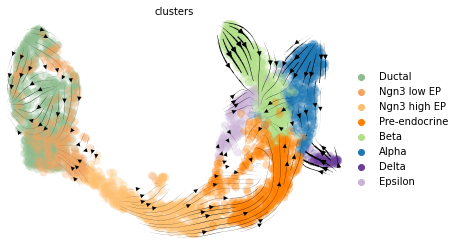

All Done.


In [3]:
for dataset in datasets:
    print(dataset)
    # Load and setup data:
    data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
    save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results/'
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    adata = c2f.utils.get_training_data(adata,
                    remove_clusters = [],
                                        cells_per_cluster = 10**6, cluster_column = 'clusters',
                                        min_shared_counts = 20, n_var_genes = 2000,
                                        n_pcs=30, n_neighbors=30)
#     file = open(data_dir + dataset + '/' + dataset + '_velocity_genes.pickle', 'rb')
#     velo_genes = pickle.load(file)
#     adata = adata[:, velo_genes]
    if sample_params['batch_size'] == 'All': sample_params['batch_size'] = adata.n_obs
    # Setup model:
    model.setup_anndata(adata)
    mod = model(adata, model_class = module, **model_params)
    # Train model:
    mod.train(use_gpu=True, batch_size = None, max_epochs = training_params['max_epochs'],
              lr = training_params['learning_rate'])
    # Export posterior:
    adata = mod.export_posterior(adata, sample_kwargs = sample_params, full_velocity_posterior = True)
    # Calculate velocity graph and plot of UMAP with arrows:
    now = datetime.now()
    date_time = now.strftime("%Y%m%d-%H%M%S")
    c2f.utils.plot_velocity_umap_Bergen2020(adata, use_full_posterior = graph_params['use_full_posterior'],
                                            n_neighbours = graph_params['n_neighbours'],
                                            spliced_key = mod.spliced_key,
                                  plotting_kwargs = {"color": 'clusters', 'legend_fontsize': 10, 'legend_loc': 'right_margin'},
                                save = save_dir + 'UMAPs/' + mod.module.model.model_name[0] + '_UMAP_' + date_time + '.png')
    # Calculate performance:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    mean_score = cross_boundary_correctness(adata = adata, k_cluster = 'clusters',
                               k_velocity = 'velocity', cluster_edges = ground_truth)[1]
    # Save results of benchmarking run:
    all_params = dict(model_params)
    all_params.update(training_params)
    all_params.update(sample_params)
    all_params.update(graph_params)
    all_params['dataset'] = dataset
    all_params['mean_score'] = mean_score
    new_tab = pd.DataFrame(columns = list(all_params.keys()), index = [date_time])
    new_tab.loc[date_time,:] = list(all_params.values())
    path_to_file = save_dir + mod.module.model.model_name[0] + 'benchmarking_results.csv'
    file_exists = exists(path_to_file)
    new_tab = new_tab.astype(str)
    if file_exists:
        new_tab.to_csv(path_to_file, mode='a', index=True, header=False)
    else:
        new_tab.to_csv(path_to_file, sep = ',')
    sample_params['batch_size'] = 'All'
print('All Done.')

In [4]:
adata.uns['velocity_posterior'] = mod.samples['posterior_samples']['beta_g'][...,0] * \
mod.adata_manager.get_from_registry('unspliced') - mod.samples['posterior_samples']['gamma_g'][...,0] * \
mod.adata_manager.get_from_registry('spliced')

In [5]:
adata.layers['velocity'] = mod.samples['post_sample_means']['beta_g'][...,0] * \
mod.adata_manager.get_from_registry('unspliced') - \
mod.samples['post_sample_means']['gamma_g'][...,0] * mod.adata_manager.get_from_registry('spliced')

computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:01:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


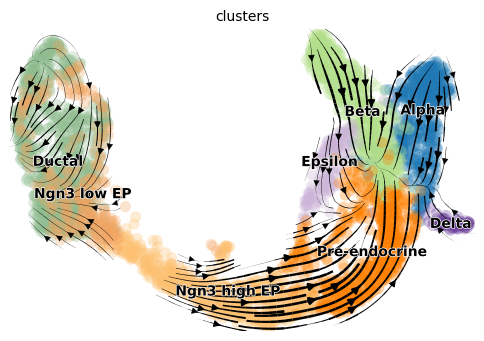

In [6]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters', dpi=100)

In [7]:
adata.var

,highly_variable_genes,gene_count_corr,means,dispersions,dispersions_norm,highly_variable,transcription_rate_mean,transcription_rate_sd,splicing_rate_mean,splicing_rate_sd,degredation_rate_mean,degredation_rate_sd,switchOFF_time_mean,switchOFF_time_sd
index,,,,,,,,,,,,,,
Sntg1,True,-0.0220,0.005065,0.131135,0.214470,True,0.905241,0.012268,1.205866,0.016880,9.692167,0.772200,12.033357,0.185177
Snhg6,False,-0.0062,0.375835,0.158586,0.040767,True,0.183269,0.000822,9.210696,0.624319,0.019015,0.000178,4.625852,0.032793
Ncoa2,False,-0.0508,0.106945,0.145878,0.298356,True,1.199382,0.004652,0.057749,0.000621,0.458130,0.019897,0.708988,0.003039
Sbspon,True,0.2311,0.143032,0.277015,1.044506,True,0.287966,0.096106,2.430425,0.483353,2.184968,0.171190,0.975911,0.118966
Ube2w,False,-0.0392,0.018522,0.109459,0.091136,True,0.650851,0.002405,0.017002,0.000902,0.492201,0.111015,0.364103,0.002362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tmem27,True,-0.1269,1.297619,2.475960,3.254981,True,5.693875,0.012401,13.053060,0.588974,0.417628,0.001077,17.235958,0.060618
Uty,False,-0.0273,0.018673,0.182256,0.505338,True,0.702638,0.005484,0.067947,0.003655,1.324179,0.320579,0.336915,0.005605
Ddx3y,True,-0.0470,0.165256,0.350977,1.465336,True,3.566646,0.037671,0.118713,0.004761,0.047401,0.004850,0.075780,0.001200


(array([1.496e+03, 3.850e+02, 7.800e+01, 2.400e+01, 8.000e+00, 5.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([ 0.02373111,  1.5988061 ,  3.1738813 ,  4.748956  ,  6.3240314 ,
         7.8991065 ,  9.474181  , 11.049256  , 12.624331  , 14.199407  ,
        15.774482  ], dtype=float32),
 <BarContainer object of 10 artists>)

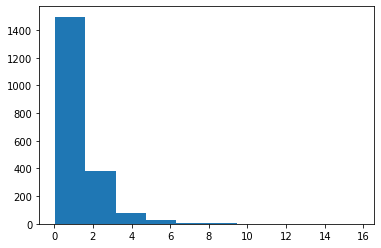

In [8]:
import matplotlib.pyplot as plt
plt.hist(mod.samples['post_sample_means']['alpha_g'].flatten())

(array([977., 475., 248., 166.,  86.,  29.,  12.,   3.,   1.,   3.]),
 array([2.4867128e-03, 2.0580294e+00, 4.1135721e+00, 6.1691146e+00,
        8.2246571e+00, 1.0280200e+01, 1.2335742e+01, 1.4391285e+01,
        1.6446827e+01, 1.8502371e+01, 2.0557913e+01], dtype=float32),
 <BarContainer object of 10 artists>)

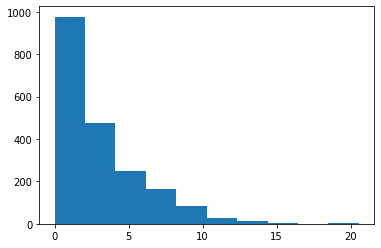

In [9]:
plt.hist(mod.samples['post_sample_means']['beta_g'].flatten())

(array([1707.,  187.,   46.,   27.,   16.,    7.,    6.,    2.,    0.,
           2.]),
 array([1.5506419e-04, 1.4394692e+00, 2.8787835e+00, 4.3180976e+00,
        5.7574120e+00, 7.1967263e+00, 8.6360407e+00, 1.0075355e+01,
        1.1514668e+01, 1.2953983e+01, 1.4393297e+01], dtype=float32),
 <BarContainer object of 10 artists>)

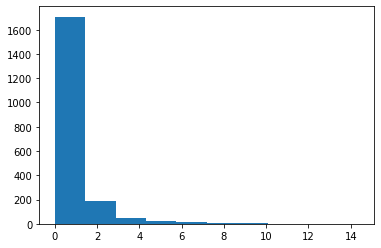

In [10]:
plt.hist(mod.samples['post_sample_means']['gamma_g'].flatten())

(array([   0.,    0.,    0.,    0.,    0., 4000.,    0.,    0.,    0.,
           0.]),
 array([ 999999.5,  999999.6,  999999.7,  999999.8,  999999.9, 1000000. ,
        1000000.1, 1000000.2, 1000000.3, 1000000.4, 1000000.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

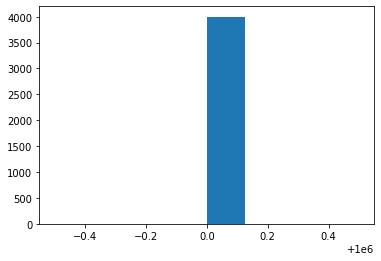

In [11]:
plt.hist(mod.samples['post_sample_means']['lam_gi'].flatten())

(array([   0.,    0.,    0.,    0.,    0., 4000.,    0.,    0.,    0.,
           0.]),
 array([ 999999.5,  999999.6,  999999.7,  999999.8,  999999.9, 1000000. ,
        1000000.1, 1000000.2, 1000000.3, 1000000.4, 1000000.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

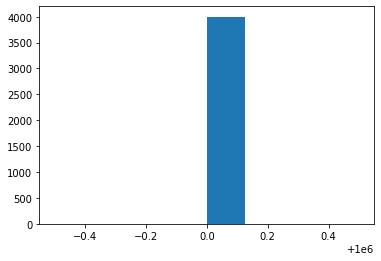

In [12]:
plt.hist(mod.samples['post_sample_means']['lam_gi'].flatten())

(array([7.212728e+06, 1.237000e+05, 3.863900e+04, 9.096000e+03,
        5.447000e+03, 1.142000e+03, 4.400000e+01, 7.200000e+01,
        5.800000e+01, 1.074000e+03]),
 array([9.5552485e-03, 8.4867775e+01, 1.6972600e+02, 2.5458421e+02,
        3.3944241e+02, 4.2430066e+02, 5.0915887e+02, 5.9401709e+02,
        6.7887531e+02, 7.6373352e+02, 8.4859174e+02], dtype=float32),
 <BarContainer object of 10 artists>)

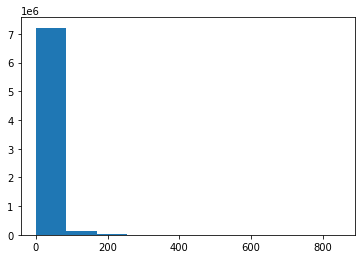

In [13]:
plt.hist(mod.samples['post_sample_means']['T_cg'].flatten())

(array([1.877e+03, 7.000e+01, 2.400e+01, 1.400e+01, 7.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([1.6145907e-02, 2.5770555e+01, 5.1524963e+01, 7.7279373e+01,
        1.0303378e+02, 1.2878819e+02, 1.5454260e+02, 1.8029701e+02,
        2.0605142e+02, 2.3180583e+02, 2.5756024e+02], dtype=float32),
 <BarContainer object of 10 artists>)

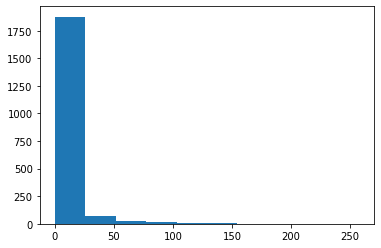

In [14]:
plt.hist(mod.samples['post_sample_means']['T_gOFF'].flatten())

(array([1.856e+03, 9.600e+01, 3.300e+01, 8.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.0972501e-01, 8.5533775e+01, 1.7085782e+02, 2.5618185e+02,
        3.4150592e+02, 4.2682996e+02, 5.1215399e+02, 5.9747803e+02,
        6.8280212e+02, 7.6812616e+02, 8.5345020e+02], dtype=float32),
 <BarContainer object of 10 artists>)

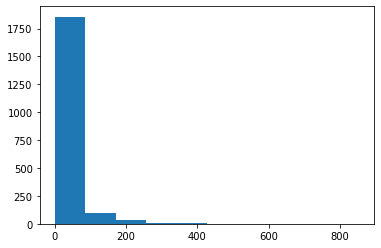

In [15]:
plt.hist(mod.samples['post_sample_means']['T_max'].flatten())

In [16]:
np.mean(mod.samples['post_sample_means']['cv'].flatten())

0.40240967

In [17]:
np.mean(mod.samples['post_sample_means']['mu'].flatten())

0.4852232

In [18]:
mod.samples['post_sample_means']['T_max'].shape

(1, 2000, 1)